## Chang-Goo's notebook

In [1]:
def int_to_roman(input):
    """ Convert an integer to a Roman numeral. """

    if not isinstance(input, type(1)):
        raise TypeError("expected integer, got %s" % type(input))
    if not 0 < input < 4000:
        raise ValueError("Argument must be between 1 and 3999")
    ints = (1000, 900,  500, 400, 100,  90, 50,  40, 10,  9,   5,  4,   1)
    nums = ('M',  'CM', 'D', 'CD','C', 'XC','L','XL','X','IX','V','IV','I')
    result = []
    for i in range(len(ints)):
        count = int(input / ints[i])
        result.append(nums[i] * count)
        input -= ints[i] * count
    return ''.join(result)

In [5]:
import periodictable as pt
import pandas as pd
import matplotlib.pyplot as plt

class GF12_table(object):
    def __init__(self):
        self.elements = self.read_ion_abundance_table_()
        self.ion_frac = self.read_ion_frac_table_()
        self.temp = self.ion_frac['temp']
        self.cie_cooling = {}
        self.cie_cooling_per_ion = {}

    def get_total_cie_cooling(self,elements=['H','He','C','N','O','Ne','Mg','Si','S','Fe']):
        total_cooling = np.zeros_like(self.temp)
        for ion_name in elements:
            element=tbl.elements.loc[ion_name]
            nion=element['number']+1
            A=element['abundance']
            total_cooling+=tbl.get_cie_cooling(ion_name)*A
            
        return total_cooling
            
    def get_cie_cooling(self,ion_name):
        nion=self.elements.loc[ion_name]['number']+1
        if not ion_name in self.cie_cooling:
            cie_cooling_ion,cie_cooling=self.read_cie_cooling_table_(ion_name)
            self.cie_cooling[ion_name]=cie_cooling
            self.cie_cooling_per_ion[ion_name]=cie_cooling_ion
        return self.cie_cooling[ion_name]
    
    def read_ion_abundance_table_(self,ion_abundance_file='../data/GnatFerland12/Table2.txt'):

        fp=open(ion_abundance_file,'r')
        lines=fp.readlines()[4:-2]
        fp.close()

        element={}
        for l in lines:
            sp=l.split('\t')
            ename=pt.elements.name(sp[1].lower())
            element[ename.symbol]={}
            element[ename.symbol]['abundance']=eval(sp[3].replace(' x 10^','e'))
            element[ename.symbol]['number']=ename.number
            element[ename.symbol]['mass']=ename.mass
            element[ename.symbol]['datafile']='../data/GnatFerland12/datafile{}.txt'.format(sp[2])

        return pd.DataFrame(element).T.sort_values('number')
    
    def read_ion_frac_table_(self,ion_frac_file='../data/GnatSternberg07_cie_ion_frac.txt'):
        #ion_frac=pd.read_table(ion_frac_file,skiprows=125,delimiter=' ',)
        fp=open(ion_frac_file,'r')
        lines=fp.readlines()
        fp.close()
        nlines=len(lines[125:])

        fields=['temp']
        ion_frac={}
        import re
        for l in lines[9:121]:
            ion_name=l.split()[-5].split('{')[0]+l[l.rfind('{')+1:max(l.rfind('{')+2,l.rfind('}')-1)].replace('+','1')
            fields.append(ion_name)
        for f in fields:
            ion_frac[f]=np.empty(nlines)
        for iline,l in enumerate(lines[125:]):
            sp=l.split()
            nfields = len(sp)
            if nfields == len(fields):
                for ifield in range(nfields):
                    ion_frac[fields[ifield]][iline]=sp[ifield]
        return ion_frac
    
    def read_cie_cooling_table_(self,ion_name):
        element=self.elements.loc[ion_name]
        nion=element['number']+1
        nskip=nion+12
        fp=open(element['datafile'],'r')
        lines=fp.readlines()
        fp.close()
        #print lines[nskip]
        temp=self.temp

        cie=[]
        for l in lines[nskip:]:
            cie.append(l.split())
        cie=np.array(cie).astype('float')

        cie_new=np.empty((len(temp),nion))
        for i in range(nion):
            cie_new[:,i]=np.interp(temp,cie[:,0],cie[:,i+1])
        total_cooling_new=np.interp(temp,cie[:,0],cie[:,-1])
        
        return cie_new,total_cooling_new
        
    def download_tables(self):
        import bs4
        import requests
        import os
        if not os.path.isdir('./data'): os.mkdir('./data')
        url = 'http://wise-obs.tau.ac.il/~orlyg/ion_by_ion/'
        r = requests.get(url)
        data = bs4.BeautifulSoup(r.text, "html.parser")
        for l in data.find_all("a"):
            if l['href'].endswith('txt'):
                r = requests.get(url + l["href"])
                if r.status_code == 200:
                    filename='./data/{}.txt'.format(l.contents[0].split()[0])
                    with open(filename, 'wb') as f:
                        f.write(r.content)
                        print('Downloading... {} to {}'.format(l['href'],filename))

In [6]:
def plot_ion_frac(tbl,ion_name):
    element=tbl.elements.loc[ion_name]
    ion_frac=tbl.ion_frac
    for i in range(element['number']+1):
        plt.loglog(ion_frac['temp'],ion_frac['{}{}'.format(ion_name,i)],
                   label='{}{}'.format(ion_name,int_to_roman(i+1)))
    plt.legend()
    plt.ylabel(r'{} $X_i$'.format(pt.elements.symbol(ion_name).name))
    plt.xlabel(r'Temperature [K]')
    
def plot_cie_cooling_ion(tbl,ion_name,ion_by_ion=True,noplot=False):
    element=tbl.elements.loc[ion_name]
    nion=element['number']+1
    A=element['abundance']
    total_cooling=tbl.get_cie_cooling(ion_name)
    if not noplot:
        l,=plt.loglog(tbl.temp,total_cooling*A,label=ion_name)
        if ion_by_ion and '{}0'.format(ion_name) in tbl.ion_frac:
            for i in range(nion):
                cie_cooling_ion=A*tbl.cie_cooling_per_ion[ion_name][:,i]*tbl.ion_frac['{}{}'.format(ion_name,i)]
                plt.loglog(tbl.temp,cie_cooling_ion,color=l.get_color(),ls=':')
    return total_cooling*A
    #plt.ylim(total_cooling.min()*0.1)
    
def plot_cie_cooling_element(tbl,elements=['H','He','C','N','O','Ne','Mg','Si','S','Fe'],ion_by_ion=True):
    total_cooling=np.zeros_like(tbl.temp)
    for ion_name in elements:
        total_cooling+=plot_cie_cooling_ion(tbl,ion_name,ion_by_ion=ion_by_ion)
    plt.plot(tbl.temp,total_cooling)
    if not ion_by_ion: plt.legend()

In [21]:
tbl = GF12_table()
# tbl.ion_frac.keys()

dict_keys(['temp', 'H0', 'H1', 'He0', 'He1', 'He2', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'N0', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'O0', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8', 'Ne0', 'Ne1', 'Ne2', 'Ne3', 'Ne4', 'Ne5', 'Ne6', 'Ne7', 'Ne8', 'Ne9', 'Ne10', 'Mg0', 'Mg1', 'Mg2', 'Mg3', 'Mg4', 'Mg5', 'Mg6', 'Mg7', 'Mg8', 'Mg9', 'Mg10', 'Mg11', 'Mg12', 'Si0', 'Si1', 'Si2', 'Si3', 'Si4', 'Si5', 'Si6', 'Si7', 'Si8', 'Si9', 'Si10', 'Si11', 'Si12', 'Si13', 'Si14', 'S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'Fe0', 'Fe1', 'Fe2', 'Fe3', 'Fe4', 'Fe5', 'Fe6', 'Fe7', 'Fe8', 'Fe9', 'Fe10', 'Fe11', 'Fe12', 'Fe13', 'Fe14', 'Fe15', 'Fe16', 'Fe17', 'Fe18', 'Fe19', 'Fe20', 'Fe21', 'Fe22', 'Fe23', 'Fe24', 'Fe25', 'Fe26'])

In [8]:
from pyathena.set_plt import *

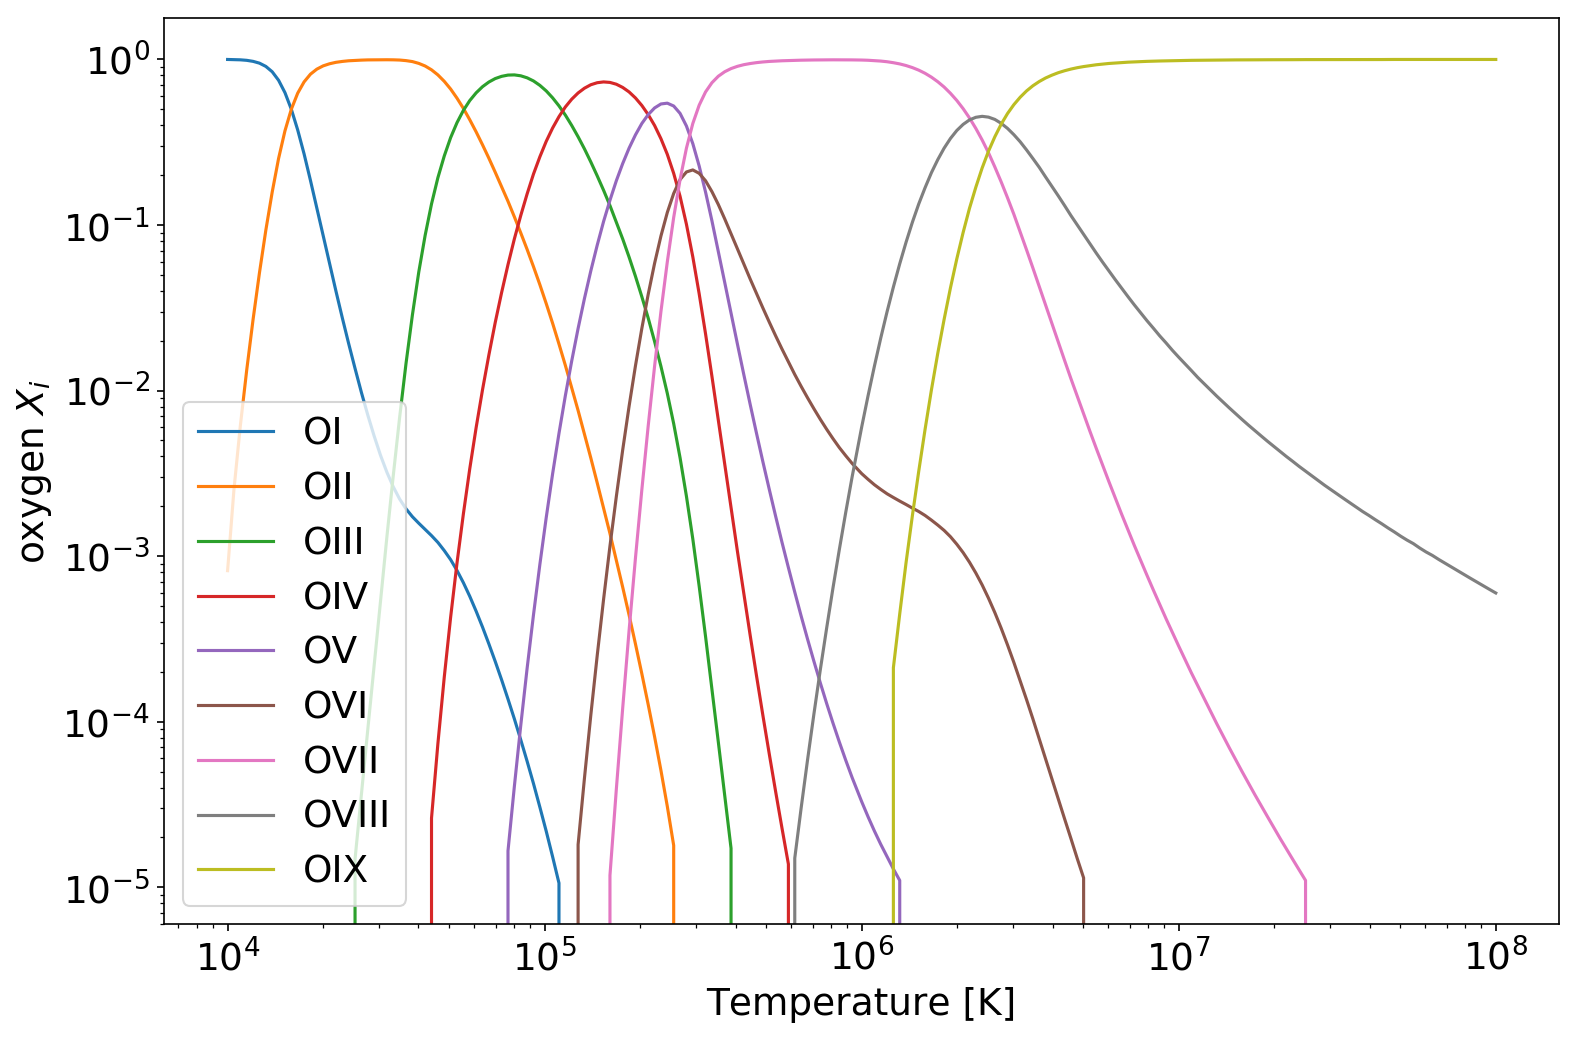

In [11]:
plt.figure(figsize=(12, 8))
plot_ion_frac(tbl,'O')

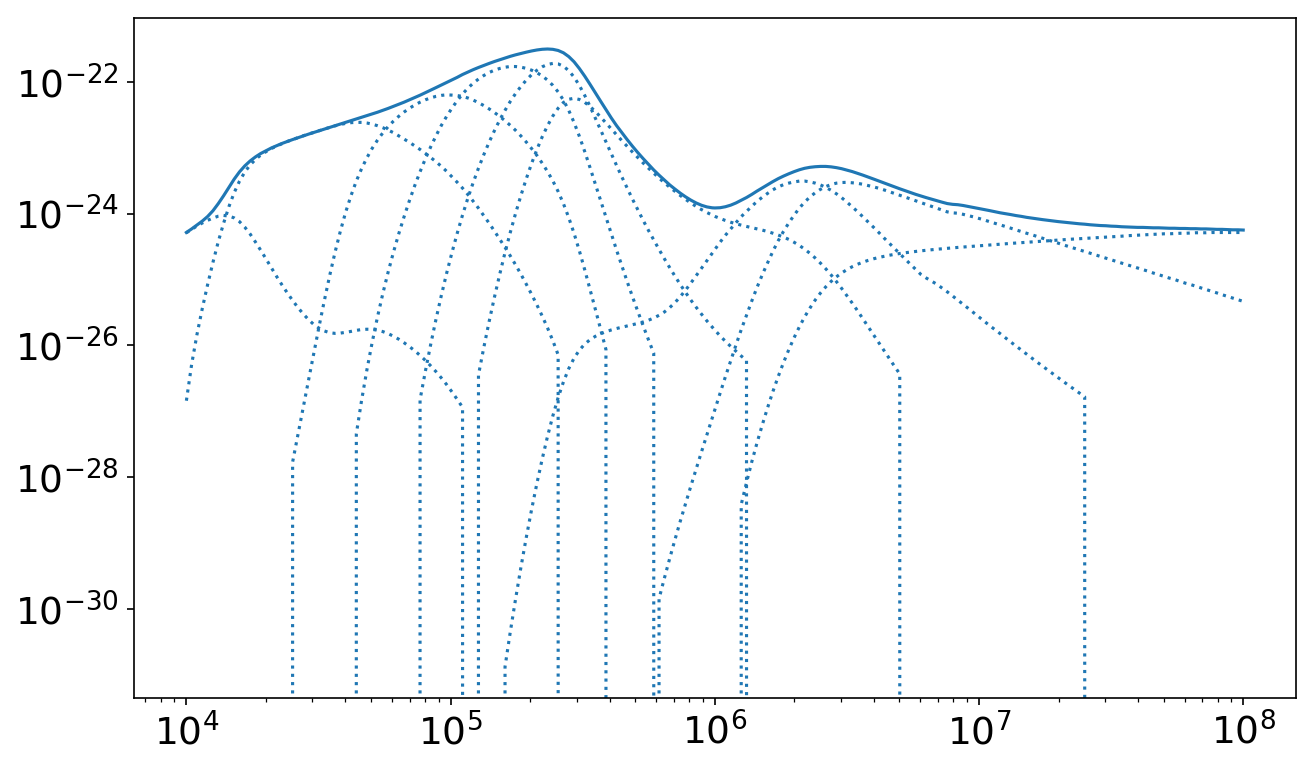

In [12]:
plot_cie_cooling_ion(tbl, 'O');

(1e-26, 1e-21)

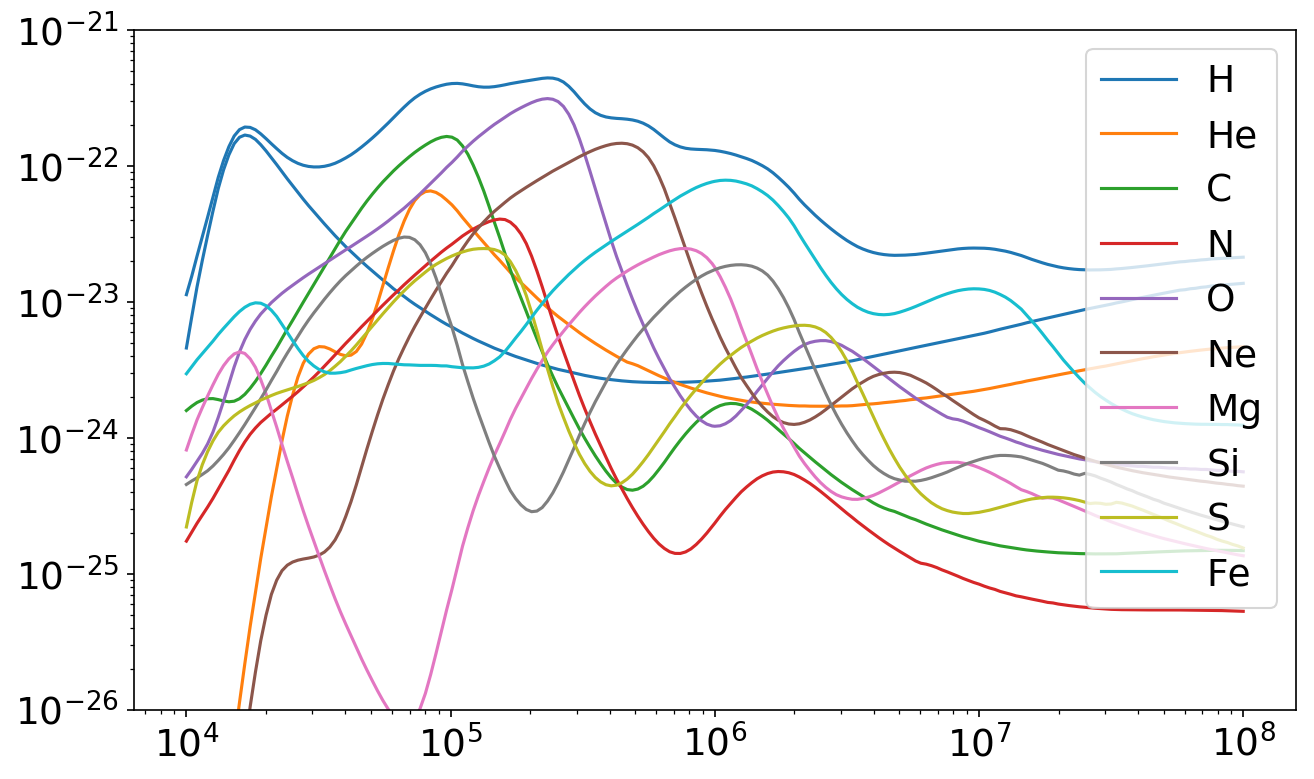

In [13]:
plot_cie_cooling_element(tbl,ion_by_ion=False)
plt.ylim(1.e-26,1.e-21)

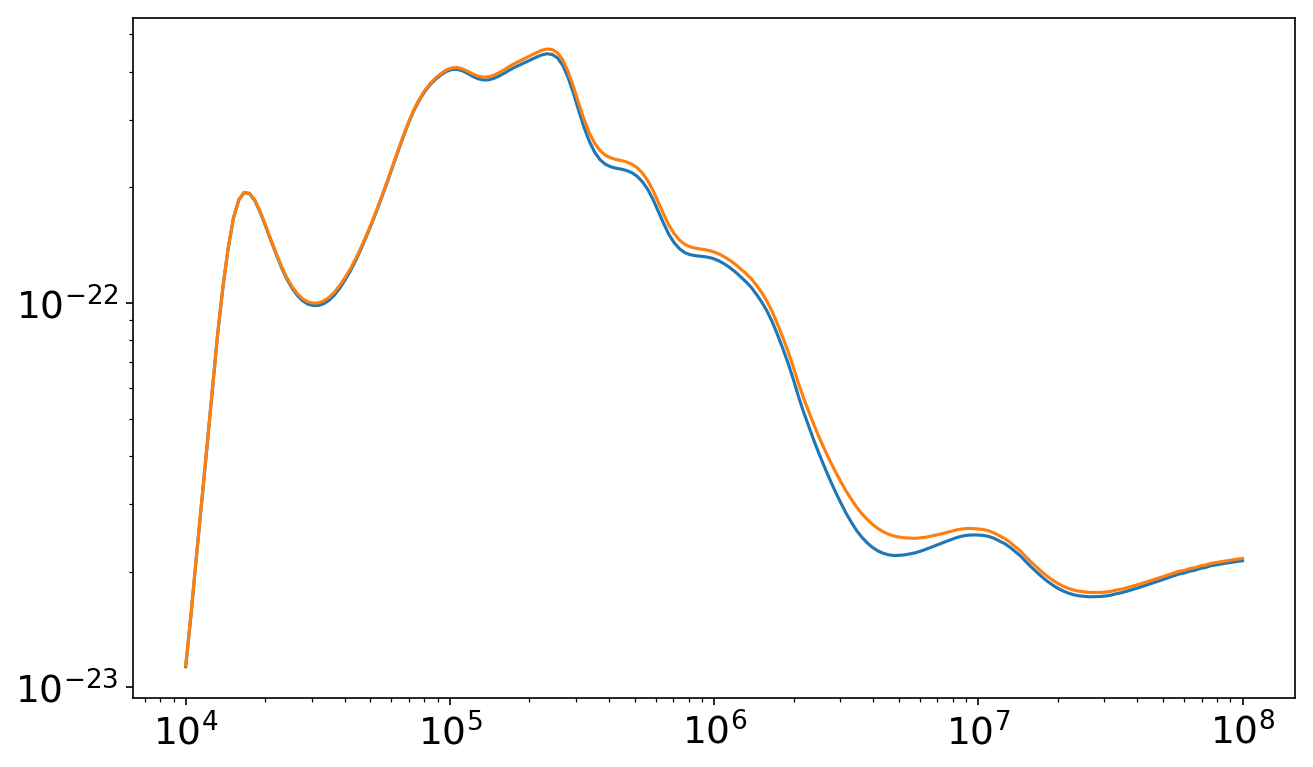

In [14]:
total_cooling=tbl.get_total_cie_cooling()
plt.loglog(tbl.temp,total_cooling)
total_cooling=tbl.get_total_cie_cooling(elements=tbl.elements.index)
plt.loglog(tbl.temp,total_cooling)